In [22]:
!pip install yfinance


[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM,Dense,Dropout
from keras.layers import Flatten,MaxPooling1D,Bidirectional,LSTM,Dropout,TimeDistributed,MaxPool2D
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mdates
from sklearn import linear_model

In [25]:
import yfinance as yf
df_final= yf.download("AMZN", start="2014-10-15", end="2024-10-15")

[*********************100%***********************]  1 of 1 completed


In [26]:
df_final.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-10-15,15.2175,15.3950,14.9550,15.2985,15.2985,106878000
2014-10-16,14.6915,15.3410,14.6915,15.1430,15.1430,94626000
2014-10-17,15.3575,15.4600,15.1360,15.1820,15.1820,88102000
2014-10-20,15.1475,15.3265,15.1010,15.3105,15.3105,64690000
2014-10-21,15.4950,15.7820,15.3535,15.7665,15.7665,71186000


In [27]:
df_final.shape

(2516, 6)

In [28]:
df_final.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03
mean,97.126900,98.231128,95.916503,97.097807,97.097807,7.717162e+07
std,53.191646,53.802083,52.509648,53.149997,53.149997,4.095630e+07
min,14.220000,14.521000,14.200000,14.347500,14.347500,1.762600e+07
25%,45.149249,45.462249,44.861000,45.114250,45.114250,5.155375e+07
50%,92.920002,94.099998,91.736248,93.083252,93.083252,6.618500e+07
75%,150.299999,152.005993,147.520874,149.997746,149.997746,9.070700e+07
max,200.089996,201.199997,199.050003,200.000000,200.000000,4.771220e+08


In [29]:
# print("checking if any null values are present\n", df.isna().sum())
df_final.isnull().values.any()

False

In [30]:
df_final = df_final.ffill()

<Axes: xlabel='Date'>

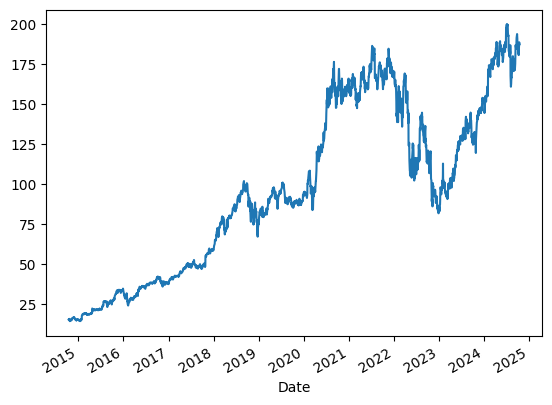

In [31]:
df_final['Adj Close'].plot()

In [32]:
X=df_final.drop(['Adj Close'],axis=1)
X=X.drop(['Close'],axis=1)

<Axes: title={'center': 'Correlation with Adj Close'}>

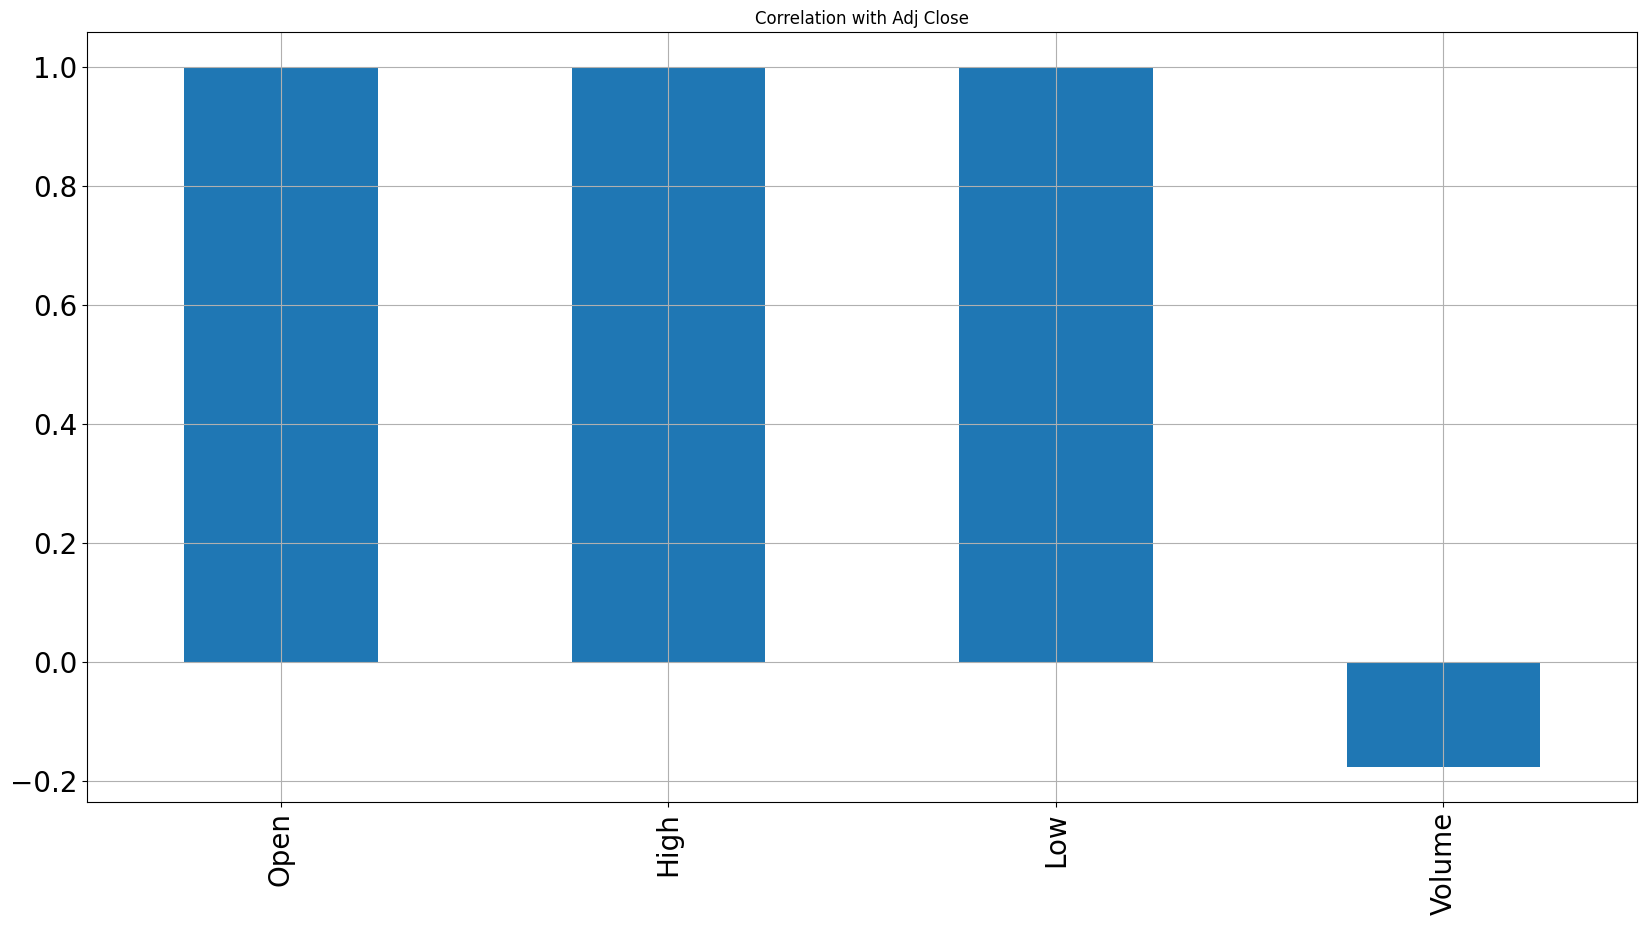

In [33]:
# Select only numeric columns from X
X_numeric = X.select_dtypes(include=[np.number])

# Compute correlation with 'Adj Close' and plot
X_numeric.corrwith(df_final['Adj Close']).plot.bar(
        figsize=(20, 10), title="Correlation with Adj Close", fontsize=20,
        rot=90, grid=True)

In [34]:
test = df_final
# Target column
target_adj_close = pd.DataFrame(test['Adj Close'])
display(test.head())

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-10-15,15.2175,15.3950,14.9550,15.2985,15.2985,106878000
2014-10-16,14.6915,15.3410,14.6915,15.1430,15.1430,94626000
2014-10-17,15.3575,15.4600,15.1360,15.1820,15.1820,88102000
2014-10-20,15.1475,15.3265,15.1010,15.3105,15.3105,64690000
2014-10-21,15.4950,15.7820,15.3535,15.7665,15.7665,71186000


In [35]:
# selecting Feature Columns
feature_columns = ['Open', 'High', 'Low', 'Volume']

In [36]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feature_minmax_transform_data = scaler.fit_transform(test[feature_columns])
feature_minmax_transform = pd.DataFrame(columns=feature_columns, data=feature_minmax_transform_data, index=test.index)
feature_minmax_transform.head()

,Open,High,Low,Volume
Date,,,,
2014-10-15,0.005367,0.004682,0.004084,0.194239
2014-10-16,0.002537,0.004393,0.002659,0.167575
2014-10-17,0.006120,0.005030,0.005064,0.153377
2014-10-20,0.004990,0.004315,0.004874,0.102425
2014-10-21,0.006860,0.006755,0.006240,0.116562


In [37]:
display(feature_minmax_transform.head())
print('Shape of features : ', feature_minmax_transform.shape)
print('Shape of target : ', target_adj_close.shape)

# Shift target array because we want to predict the n + 1 day value


target_adj_close = target_adj_close.shift(-1)
validation_y = target_adj_close[-90:-1]
target_adj_close = target_adj_close[:-90]

# Taking last 90 rows of data to be validation set
validation_X = feature_minmax_transform[-90:-1]
feature_minmax_transform = feature_minmax_transform[:-90]
display(validation_X.tail())
display(validation_y.tail())

print("\n -----After process------ \n")
print('Shape of features : ', feature_minmax_transform.shape)
print('Shape of target : ', target_adj_close.shape)
display(target_adj_close.tail())

,Open,High,Low,Volume
Date,,,,
2014-10-15,0.005367,0.004682,0.004084,0.194239
2014-10-16,0.002537,0.004393,0.002659,0.167575
2014-10-17,0.006120,0.005030,0.005064,0.153377
2014-10-20,0.004990,0.004315,0.004874,0.102425
2014-10-21,0.006860,0.006755,0.006240,0.116562


Shape of features :  (2516, 4)
Shape of target :  (2516, 1)


,Open,High,Low,Volume
Date,,,,
2024-10-07,0.907785,0.905721,0.898296,0.053838
2024-10-08,0.902244,0.902989,0.901920,0.019034
2024-10-09,0.907086,0.917773,0.908034,0.018971
2024-10-10,0.930274,0.929987,0.928483,0.022109
2024-10-11,0.927584,0.939629,0.931025,0.017684


,Adj Close
Date,
2024-10-07,182.720001
2024-10-08,185.169998
2024-10-09,186.649994
2024-10-10,188.820007
2024-10-11,187.539993



 -----After process------ 

Shape of features :  (2426, 4)
Shape of target :  (2426, 1)


,Adj Close
Date,
2024-05-30,176.440002
2024-05-31,178.339996
2024-06-03,179.339996
2024-06-04,181.279999
2024-06-05,185.000000


In [38]:
# Time series split
ts_split = TimeSeriesSplit(n_splits=10)
for train_index, test_index in ts_split.split(feature_minmax_transform):
    X_train, X_test = feature_minmax_transform[:len(train_index)], feature_minmax_transform[len(train_index):(len(train_index) + len(test_index))]
    y_train, y_test = target_adj_close[:len(train_index)].values.ravel(), target_adj_close[len(train_index):(len(train_index) + len(test_index))].values.ravel()

In [39]:
X_train.shape

(2206, 4)

In [40]:
X_test.shape

(220, 4)

In [41]:
y_train.shape

(2206,)

In [42]:
y_test.shape

(220,)

In [43]:
X_train =np.array(X_train)
X_test =np.array(X_test)

X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print( X_train.shape[1])

4


In [44]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM

In [45]:
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(16, input_shape=(1, X_train.shape[1]), activation='relu', return_sequences=False))
model_lstm.add(Dense(16))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

# Early stopping
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)

# Fit the model
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=40, batch_size=8, verbose=1, shuffle=False)

C:\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2898.2556
Epoch 2/40
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 187.9884
Epoch 3/40
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 163.8236
Epoch 4/40
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 131.0752
Epoch 5/40
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 103.2609
Epoch 6/40
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 80.1202
Epoch 7/40
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 60.7860
Epoch 8/40
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 45.6119
Epoch 9/40
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 34.3957
Epoch 10/40
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 26.6125
Epoch 11/40
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 21.4283
Epoch 12/40
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 18.0382
Epoch 13/40
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.8118
Epoch 14/40
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 14.3322
Epoch 15/40
276/276 ━━━━━━━━━━━━━━━━━

In [46]:
# Evaluate the model
predicted = model_lstm.predict(X_tst_t)
test_label = y_test

# Calculate RMSE and R² Score
rmse = np.sqrt(mean_squared_error(test_label, predicted))
r2 = r2_score(test_label, predicted)
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
RMSE: 3.878770676157907
R² Score: 0.9643152245411762


In [47]:
score_lstm= model_lstm.evaluate(X_tst_t, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.0382 


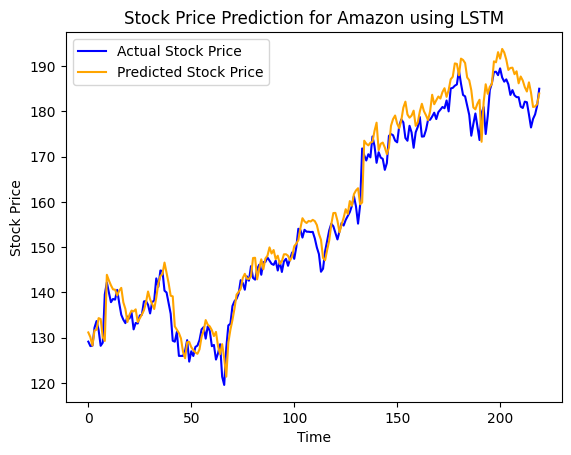

In [48]:
# Plotting results
plt.plot(test_label, color='blue', label='Actual Stock Price')
plt.plot(predicted, color='orange', label='Predicted Stock Price')
plt.title('Stock Price Prediction for Amazon using LSTM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [51]:
col1 = pd.DataFrame(y_test, columns=['True'])

col2 = pd.DataFrame(predicted, columns=['LSTM_prediction'])

# col3 = pd.DataFrame(history_model_lstm.history['loss'], columns=['Loss_LSTM'])
results = pd.concat([col1, col2], axis=1)
results.to_excel('Predicted_LSTM.xlsx')